<a href="https://colab.research.google.com/github/aaronhowellai/machine-learning-projects/blob/main/machine%20learning%20algorithms/Taxi%20Cost%20Prediction%20ANN%20with%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taxi Cost Prediction ANN with PyTorch** 🚖
Following tutorials and guidance by Pierian Data's "PyTorch for Deep Learning Bootcamp" on Udemy.

## **Aims for this notebook** 🎯

### **Dataset**
[Google Cloud NYC Taxi Fares Competition Dataset](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction)
* The New York City Taxi Fares dataset used in this notebook is from a Kaggle competition (originally with 55 million records which for download and training time purposes has been reduced to 120,000 records).

  * The data contained information about Taxi rides such as:
    * Pickup date
    * Pickup time
    * Latitude & longitude (GPS Coordinates)
    * Pickup location
    * Dropoff location
    * Number of passengers

### **Objective with Dataset**
* With the data available, using a Machine Learning model, I aim to accurately predict what a Taxi will charge for a ride.

  * Given the number of features, it will be crucial to discard the least relevant features during the Exploratory Data Analysis stage which will tell me which of these information categories in the dataset contribute most to accurate predictions.

### **Possible Questions to ask during Data Analysis**
* Does the time of day matter?
* Are there locations that often cost more than others?
* How is distanced determined from two GPS points?
* Is there a range of varying prices between days of the week?

## **Project Steps** 📋
  1. Read in the data
  2. Feature Engineering
    * Calculate distance travelled with GPS information with the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula)
    * Derive useful Date and Time statistics

  3. Encode and deal with Categorical Data (changing non-numerical formats to numerical)
    * Embedding
  4. Use a Tabular Data model *class* to work with both categorical data and continuous data (floating points).
  5. Add a loss function (function to measure model's error rates during training) and an optimizer (optimisation algorithm for minimising the loss function which finds optimal weights and biases)
  6. Train/test split the data
  7. Train the model
  8. Evaluate the Model

# **Packages** 📦
* Import relevant packages for the project.

In [1]:
# import packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import time

# machine learning packages
from sklearn.model_selection import train_test_split

# deep learning packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# settings
torch.set_printoptions(edgeitems=2)

# **1. Data Import & Data Analysis**

In [2]:
# import data
df = pd.read_csv('https://raw.githubusercontent.com/aaronhowellai/machine-learning-projects/main/datasets/NYCTaxiFares.csv')

In [3]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [4]:
# no missing values
df.count()

,0
pickup_datetime,120000
fare_amount,120000
fare_class,120000
pickup_longitude,120000
pickup_latitude,120000
dropoff_longitude,120000
dropoff_latitude,120000
passenger_count,120000


In [5]:
# describe fare amount feature
df['fare_amount'].describe()

,fare_amount
count,120000.000000
mean,10.040326
std,7.500134
min,2.500000
25%,5.700000
50%,7.700000
75%,11.300000
max,49.900000


# **2. Feature Engineering**

## **2.1. Create a new distance travelled feature**
* Calculate distance travelled with GPS information with the Haversine formula

In [6]:
def haversine_distance(df, lat1, long1, lat2, long2):
  """
  Calculates the haversine distance between 2 sets of GPS coordinates in df
  """
  r = 6371 # average radius of earth in kilometers

  phi1 = np.radians(df[lat1])
  phi2 = np.radians(df[lat2])

  delta_phi = np.radians( df[lat2] - df[lat1] )
  delta_lambda = np.radians( df[long2] - df[long1] )

  a = np.sin( (delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2 )
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
  d = r * c # in km

  return d

In [7]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [8]:
df['dist_km'] = haversine_distance(
    df,
    'pickup_latitude',
    'pickup_longitude',
    'dropoff_latitude',
    'dropoff_longitude'
    )

In [9]:
df['dist_km'].head()

,dist_km
0,2.126312
1,1.392307
2,3.326763
3,1.864129
4,7.231321


In [10]:
df['dist_km'].describe()

,dist_km
count,120000.000000
mean,3.322160
std,3.337005
min,0.010208
25%,1.316428
50%,2.237084
75%,4.034564
max,28.846384


### **Using Aggregate Functions to View Distance vs Fare Amounts**

In [11]:
df.groupby('dist_km')['fare_amount'].max()

,fare_amount
dist_km,
0.010208,49.57
0.010210,14.00
0.010250,2.90
0.010353,48.00
0.010477,49.57
...,...
26.781614,49.07
26.911172,49.57
26.976547,43.30


In [12]:
df.groupby('dist_km')['fare_amount'].mean()

,fare_amount
dist_km,
0.010208,49.57
0.010210,14.00
0.010250,2.90
0.010353,48.00
0.010477,49.57
...,...
26.781614,49.07
26.911172,49.57
26.976547,43.30


## **2.2. Create a new Date and Time feature**
* Derive useful Date and Time statistics

In [13]:
# the datetime feature is an object:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_km            120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


In [14]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_km            120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


* Hours, minutes and days can now be extracted

In [16]:
df['pickup_datetime'][0]

Timestamp('2010-04-19 08:17:56+0000', tz='UTC')

In [17]:
my_time = df['pickup_datetime'][0]

In [18]:
my_time.day

19

In [19]:
my_time.hour

8

### **Adjust Datetime Feature for April Daylight savings time**

In [20]:
df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

### **Creating New Aggregate Features**
* These features well help to differentiate times of day in the most statistically descriptive and useful way.

In [21]:
df['Hour'] = df['EDTdate'].dt.hour

In [22]:
# Is the hour greater or less than 12
df['AM_or_PM'] = np.where(df['Hour']<12,'am','pm')

In [23]:
df.iloc[:,-4:].head()

,dist_km,EDTdate,Hour,AM_or_PM
0,2.126312,2010-04-19 04:17:56+00:00,4,am
1,1.392307,2010-04-17 11:43:53+00:00,11,am
2,3.326763,2010-04-17 07:23:26+00:00,7,am
3,1.864129,2010-04-11 17:25:03+00:00,17,pm
4,7.231321,2010-04-16 22:19:01+00:00,22,pm


In [24]:
df['Weekday'] = df['EDTdate'].dt.strftime('%a')

### **Categorical Features**

In [25]:
df.iloc[:,-5:].head()

,dist_km,EDTdate,Hour,AM_or_PM,Weekday
0,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


# **3. Encode and deal with Categorical Data**
* Changing some variable types to be easier to work with.

In [26]:
# check the full head again
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AM_or_PM,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,Mon
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,Sat
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,Sat
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,Sun
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,pm,Fri


In [27]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AM_or_PM', 'Weekday'],
      dtype='object')

In [28]:
# separate categorical variables
cat_cols = ['Hour','AM_or_PM','Weekday']
cont_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km']

In [29]:
y_col = ['fare_amount']

In [30]:
df.dtypes

,0
pickup_datetime,"datetime64[ns, UTC]"
fare_amount,float64
fare_class,int64
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
passenger_count,int64
dist_km,float64
EDTdate,"datetime64[ns, UTC]"


In [31]:
# change 'Hour' into categorical variable
for cat in cat_cols:
  df[cat] = df[cat].astype('category')

In [32]:
df.dtypes

,0
pickup_datetime,"datetime64[ns, UTC]"
fare_amount,float64
fare_class,int64
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
passenger_count,int64
dist_km,float64
EDTdate,"datetime64[ns, UTC]"


In [33]:
df['Hour'].head()

,Hour
0,4
1,11
2,7
3,17
4,22


In [34]:
df['Hour'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 120000 entries, 0 to 119999
Series name: Hour
Non-Null Count   Dtype   
--------------   -----   
120000 non-null  category
dtypes: category(1)
memory usage: 117.8 KB


In [35]:
df['Hour'].values

[4, 11, 7, 17, 22, ..., 10, 6, 14, 4, 12]
Length: 120000
Categories (24, int32): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [36]:
df['AM_or_PM'].values

['am', 'am', 'am', 'pm', 'pm', ..., 'am', 'am', 'pm', 'am', 'pm']
Length: 120000
Categories (2, object): ['am', 'pm']

In [37]:
df['Weekday'].values

['Mon', 'Sat', 'Sat', 'Sun', 'Fri', ..., 'Sun', 'Fri', 'Sun', 'Tue', 'Sat']
Length: 120000
Categories (7, object): ['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed']

In [38]:
df['Weekday'].cat.categories

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype='object')

In [39]:
df['Weekday'].cat.codes.values

array([1, 2, 2, ..., 3, 5, 2], dtype=int8)

In [40]:
# converting numpy arrays to stack
hr = df['Hour'].cat.codes.values
ampm = df['AM_or_PM'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

In [41]:
# list comprehension method
# cats = np.stack([df[cols].cat.codes.values for col in cat_cols], 1)

In [42]:
cats = np.stack([hr, ampm, wkdy],axis=1)

In [43]:
cats

array([[ 4,  0,  1],
       [11,  0,  2],
       [ 7,  0,  2],
       ...,
       [14,  1,  3],
       [ 4,  0,  5],
       [12,  1,  2]], dtype=int8)

In [44]:
# convert numpy array to tensor
cats = torch.tensor(cats,dtype=torch.int64)

In [45]:
conts = np.stack([df[col].values for col in cont_cols],axis=1)

In [46]:
conts = torch.tensor(conts,dtype=torch.float)

In [47]:
y = torch.tensor(df[y_col].values,dtype=torch.float)

In [48]:
y

tensor([[6.5000],
        [6.9000],
        ...,
        [4.9000],
        [5.3000]])

In [49]:
y.shape

torch.Size([120000, 1])

In [50]:
cats.shape

torch.Size([120000, 3])

In [51]:
conts.shape

torch.Size([120000, 6])

## **3.2 Set embedding sizes for categorical columns**

In [52]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [53]:
# how many categories for each variable
cat_szs

[24, 2, 7]

In [54]:
emb_szs = [(size, min(50,size+1)//2) for size in cat_szs]

In [55]:
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [56]:
catz = cats[:2]
catz

tensor([[ 4,  0,  1],
        [11,  0,  2]])

In [57]:
selfembeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])

In [58]:
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(2, 1)
  (2): Embedding(7, 4)
)

In [59]:
# testing embedding forward method with subset
embeddingz = []

for i,e in enumerate(selfembeds):
  embeddingz.append(e(catz[:,i]))

#### **Assigning Values to the OneHot encoded data**

In [60]:
embeddingz

[tensor([[-0.8216,  1.4418, -0.8307,  0.1912, -0.5204,  0.5159, -0.1652,  0.6469,
           0.9104,  0.6528, -0.6775, -0.5168],
         [-0.6561,  0.8824,  0.1140, -0.9387,  1.2933,  1.6124, -0.0043,  0.6798,
          -0.4870, -0.1563, -0.3854, -0.1657]], grad_fn=<EmbeddingBackward0>),
 tensor([[0.2130],
         [0.2130]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.7763, -0.0907, -0.7534, -0.1908],
         [-0.4335, -1.8025, -0.6338,  1.0175]], grad_fn=<EmbeddingBackward0>)]

In [61]:
z = torch.cat(embeddingz,1)
z

tensor([[-0.8216,  1.4418, -0.8307,  0.1912, -0.5204,  0.5159, -0.1652,  0.6469,
          0.9104,  0.6528, -0.6775, -0.5168,  0.2130, -0.7763, -0.0907, -0.7534,
         -0.1908],
        [-0.6561,  0.8824,  0.1140, -0.9387,  1.2933,  1.6124, -0.0043,  0.6798,
         -0.4870, -0.1563, -0.3854, -0.1657,  0.2130, -0.4335, -1.8025, -0.6338,
          1.0175]], grad_fn=<CatBackward0>)

In [62]:
selfembeddrop = nn.Dropout(0.4) # randomly disable 40% of the neurons

In [63]:
z = selfembeddrop(z)

In [64]:
z

tensor([[-0.0000,  2.4031, -1.3845,  0.0000, -0.0000,  0.8599, -0.0000,  1.0782,
          1.5174,  0.0000, -0.0000, -0.8613,  0.0000, -1.2939, -0.1511, -0.0000,
         -0.3180],
        [-1.0934,  1.4707,  0.1900, -0.0000,  0.0000,  2.6873, -0.0072,  1.1330,
         -0.0000, -0.2604, -0.6424, -0.0000,  0.3551, -0.7225, -3.0042, -1.0563,
          1.6959]], grad_fn=<MulBackward0>)

# **4. Tabular Model**
* Use a Tabular Data model class to work with both categorical data and continuous data (floating points).
  * Define a model based on the number of continuous columns (given by `conts.shape[1]`) + the number of categorical columns and their embeddings (given by `len(emb_szs)` and `emb_szs` respectively).
  * The output would either be a regression (single float value) or a classification (a group of bins and their softmax values).

In [65]:
class TabularModel(nn.Module):

  def __init__(
      self,
      emb_szs, # list of tuples: each categorical variable size is paired with an embedding size
      n_cont, # int: number of continuous variables
      out_sz, # int: output size
      layers, # list of ints: layer sizes
      p=0.5 # float: dropout probability of each layer (currently constant opposed to adaptive through layers)
      ):

    super().__init__()

    # set up the embedded layers with `nn.ModuleList()` and `nn.Embedding()`
    # >> categorical data will be filteref through these Embeddings in the forward section
    self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])

    # set up a dropout function for the embeddings with `nn.Dropout()`
    self.emb_drop = nn.Dropout(p)

    # set up a normalization function for the continuous variables with `nn.BatchNorm1d`
    self.bn_cont = nn.BatchNorm1d(n_cont)

    # set up a sequence of neural network layers where each level includes:
    # >> a Linear function
    # >> an Activation function
    # >> a Normalization step
    # >> and a Dropout layer
    # the list is combined with `nn.Sequential()`

    layerlist = []
    n_emb = sum([nf for ni,nf in emb_szs])
    n_in = n_emb + n_cont

    for i in layers:
      layerlist.append(nn.Linear(n_in,i))
      layerlist.append(nn.ReLU(inplace=True))
      layerlist.append(nn.BatchNorm1d(i))
      layerlist.append(nn.Dropout(p))
      n_in = i

    layerlist.append(nn.Linear(layers[-1],out_sz))

    self.layers = nn.Sequential(*layerlist)

  # define the forward method
  # >> Preprocess the embeddings and normalize the continuous variables before passing them through the layers.
  # >> `torch.cat()` combines multiple tensors into one.

  def forward(
      self,
      x_cat,
      x_cont
      ):

    embeddings = []

    for i,e in enumerate(self.embeds):

      embeddings.append(e(x_cat[:,i]))

    x = torch.cat(embeddings,1)
    x = self.emb_drop(x)

    x_cont = self.bn_cont(x_cont)
    x = torch.cat([x,x_cont],1)
    return self.layers(x)

In [84]:
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        for i in layers:
            layerlist.append(nn.Linear(n_in,i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        self.layers = nn.Sequential(*layerlist)
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        return self.layers(x)

# **5. Define Loss Function Optimizer for Tabular Model**
* Add a loss function (function to measure model's error rates during training) and an optimizer (optimisation algorithm for minimising the loss function which finds optimal weights and biases)

In [85]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1],1,[200,100],p=0.4)

In [86]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [87]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

# **6. Perform Train/test split**

In [88]:
batch_size = 60000
test_size = int(batch_size * 0.2)

In [89]:
# data is shuffled already
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

In [90]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [91]:
[print(len(item)) for item in [cat_train,con_train,cat_test,con_test]]

48000
48000
12000
12000


[None, None, None, None]

# **7. Perform Model Training**

### **Track how long training time takes**

In [92]:
start_time = time.time()
epochs = 300
losses = []

for i in range(epochs):
  i+=1

  y_pred = model(cat_train,con_train)
  # RMSE
  loss = torch.sqrt(criterion(y_pred,y_train))
  losses.append(loss)

  if i%10==1:
    print(f'epoch {i}, loss is {loss}')

  # backpropagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


duration = time.time() - start_time
print(f'Training took {duration/60} minutes')

epoch 1, loss is 12.586103439331055
epoch 11, loss is 11.692545890808105
epoch 21, loss is 11.116925239562988
epoch 31, loss is 10.730051040649414
epoch 41, loss is 10.460408210754395
epoch 51, loss is 10.235311508178711
epoch 61, loss is 10.029400825500488
epoch 71, loss is 9.85008716583252
epoch 81, loss is 9.635750770568848
epoch 91, loss is 9.414334297180176
epoch 101, loss is 9.173970222473145
epoch 111, loss is 8.89433765411377
epoch 121, loss is 8.577521324157715
epoch 131, loss is 8.21644115447998
epoch 141, loss is 7.807110786437988
epoch 151, loss is 7.363897800445557
epoch 161, loss is 6.917297840118408
epoch 171, loss is 6.455254077911377
epoch 181, loss is 5.967628002166748
epoch 191, loss is 5.46019172668457
epoch 201, loss is 5.016585350036621
epoch 211, loss is 4.627999782562256
epoch 221, loss is 4.3413262367248535
epoch 231, loss is 4.103150844573975
epoch 241, loss is 3.9135191440582275
epoch 251, loss is 3.8913955688476562
epoch 261, loss is 3.8007967472076416
epoch

## **Plot the Gradient Descent**

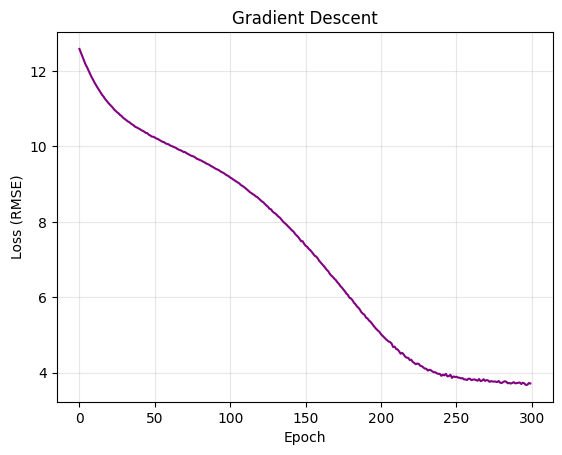

In [93]:
# convert losses to a numpy array
np_losses = [loss.detach().cpu().numpy() for loss in losses]
plt.plot(range(epochs),np_losses,color='purple')
plt.title('Gradient Descent')
plt.xlabel('Epoch')
plt.ylabel('Loss (RMSE)')
plt.grid(alpha=.3)
plt.show()

# **8. Evaluate The Model on Test Set**
* On average, the model predictions are $\pm$ $3.65 per price prediction.

In [94]:
with torch.no_grad():
  y_val = model(cat_test, con_test)
  loss = torch.sqrt(criterion(y_val,y_test))

In [95]:
print('RMSE:',loss)

RMSE: tensor(3.6464)


## **Difference Between Predictions and True Values**
* First 20 predicted values.

In [96]:
print(f"{'PREDICTED':>12} {'ACTUAL':>8} {'DIFF':>8}")
for i in range(20):
  diff = np.abs(y_val[i].item() - y_test[i].item())
  print(f'{i+1:2}. {y_val[i].item():8.2f} {y_test[i].item():8.2f} {diff:8.2f}')

   PREDICTED   ACTUAL     DIFF
 1.     4.77     2.90     1.87
 2.    13.65     5.70     7.95
 3.     7.50     7.70     0.20
 4.    13.55    12.50     1.05
 5.     7.18     4.10     3.08
 6.     5.79     5.30     0.49
 7.     1.37     3.70     2.33
 8.    19.16    14.50     4.66
 9.     4.85     5.70     0.85
10.    13.84    10.10     3.74
11.     7.56     4.50     3.06
12.     2.77     6.10     3.33
13.     4.79     6.90     2.11
14.     9.11    14.10     4.99
15.     5.86     4.50     1.36
16.    28.24    34.10     5.86
17.    -0.05    12.50    12.55
18.     5.08     4.10     0.98
19.     9.72     8.50     1.22
20.     3.69     5.30     1.61


## **Save The Model**

In [98]:
if len(losses) == epochs:
  torch.save(model.state_dict(),'TaxiModel_Regression_Newer.pt')
else:
  print('Model has not been trained. Consider loading a trained model instead')

### **Create New Model From Load State**

In [99]:
emb_szs = [(24, 12), (2, 1), (7, 4)]
model2 = TabularModel(emb_szs, 6, 1, [200,100], p=0.4)

In [102]:
model2.load_state_dict(torch.load('TaxiModel.pt'));
model2.eval()

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)